# Análisis de Clústering


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sys
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch


### Análisis de Agrupamiento de datos realizados


<small>

**Perfil básico de la víctima**
1. VICTIMA_EDAD
2. VICTIMA_ESCOLARIDAD

**Perfil ocupacional de la víctima**
1. VICTIMA_OCUP
2. VICTIMA_DEDICA
3. VICTIMA_TRABAJA

**Perfil básico del agresor**
1. AGRESOR_EDAD
2. AGRESOR_ESCOLARIDAD

**Perfil ocupacional del agresor**
1. AGRESOR_OCUP
2. AGRESOR_DEDICA
3. AGRESOR_TRABAJA

**Relación y tipo de agresión**
1. VICTIMA_RELACION_AGRESOR
2. HEC_TIPAGRE
3. VICTIMA_EDAD

**Contexto geográfico del hecho**
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO
3. VICTIMA_TRABAJA

</small>


### Cargar DataFrame


In [2]:
df = pd.read_csv("../CSV/UnidoPorAñoCSV/vif_all_years.csv")

C:\Users\diego\AppData\Local\Temp\ipykernel_25592\555449755.py:1: DtypeWarning: Columns (0,3,7,8,9,10,11,12,15,16,17,19,28,29,31,33,38,42,43,45,48,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../CSV/UnidoPorAñoCSV/vif_all_years.csv")


Análisis de Matriz de Correlación

In [3]:
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]


C:\Users\diego\AppData\Local\Temp\ipykernel_25592\23183120.py:14: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


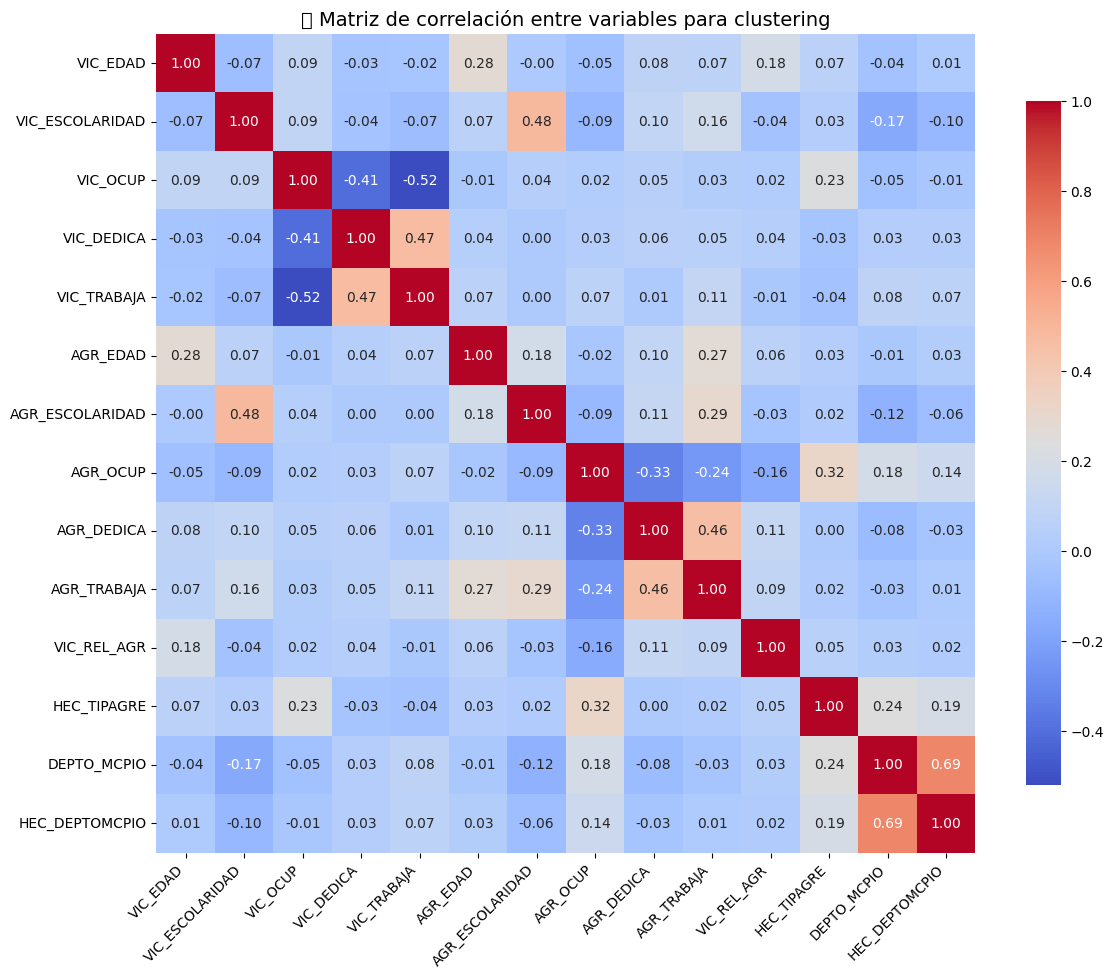

In [4]:
# Crear el mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
df_corr = df[columnas_para_clustering].apply(pd.to_numeric, errors='coerce').fillna(0)
sns.heatmap(
    df_corr.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("🔗 Matriz de correlación entre variables para clustering", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [5]:
print(df_corr.corr())

                 VIC_EDAD  VIC_ESCOLARIDAD  VIC_OCUP  VIC_DEDICA  VIC_TRABAJA  \
VIC_EDAD         1.000000        -0.068554  0.092458   -0.031249    -0.024935   
VIC_ESCOLARIDAD -0.068554         1.000000  0.091352   -0.038570    -0.069843   
VIC_OCUP         0.092458         0.091352  1.000000   -0.405082    -0.520610   
VIC_DEDICA      -0.031249        -0.038570 -0.405082    1.000000     0.472630   
VIC_TRABAJA     -0.024935        -0.069843 -0.520610    0.472630     1.000000   
AGR_EDAD         0.279821         0.065050 -0.005835    0.043080     0.067339   
AGR_ESCOLARIDAD -0.000432         0.484293  0.040847    0.004838     0.002381   
AGR_OCUP        -0.054343        -0.092996  0.022430    0.032841     0.069066   
AGR_DEDICA       0.077451         0.101193  0.047560    0.058500     0.006777   
AGR_TRABAJA      0.071562         0.163471  0.026638    0.051890     0.107421   
VIC_REL_AGR      0.183864        -0.044391  0.020837    0.042535    -0.006531   
HEC_TIPAGRE      0.065463   

### Limpieza de Datos


In [6]:
# 🔽 1. Solo las columnas necesarias desde el inicio
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]

df_temp = df[columnas_para_clustering].copy()

# 🔽 2. Reemplazar solo en estas columnas (no en todo el DataFrame)
df_temp.replace('', pd.NA, inplace=True)
df_temp = df_temp.apply(pd.to_numeric, errors='coerce')
df_temp.fillna(0, inplace=True)

# 🔽 3. Escalar
scaler = StandardScaler()
df_clustering = scaler.fit_transform(df_temp)
df_ready = pd.DataFrame(df_clustering, columns=columnas_para_clustering)

# 🔽 4. Crear estrato sobre columnas discretas (¡no todas!)
columnas_para_estrato = [
    'VIC_ESCOLARIDAD', 'VIC_OCUP', 'VIC_TRABAJA',
    'AGR_ESCOLARIDAD', 'AGR_OCUP', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]
df_estrato = df_temp[columnas_para_estrato].astype(str)
df_temp["estrato"] = df_estrato.agg("_".join, axis=1)

# 🔽 5. Muestreo estratificado (con mínimo 1 por grupo)
df_sample = df_temp.groupby("estrato", group_keys=False).apply(
    lambda x: x.sample(n=min(max(1, int(len(x) * 0.05)), len(x)), random_state=42)
)

# 🔽 6. Subset del DataFrame escalado
df_ready_sample = df_ready.loc[df_sample.index]

# ✅ Vista previa
print(f"✅ Muestra creada: {df_ready_sample.shape}")
print(df_ready_sample.head())

KeyboardInterrupt: 

### Agrupamiento por clusters predichos


In [ ]:
# Clustering del perfil básico de la víctima
grupo_perfil_victima = [
    "VIC_EDAD",
    "VIC_ESCOLARIDAD"
]

# Clustering del perfil ocupacional de la víctima
grupo_ocupacion_victima = [
    "VIC_OCUP",
    "VIC_DEDICA",
]

# Clustering del perfil básico del agresor
grupo_perfil_agresor = [
    "AGR_EDAD",
    "AGR_ESCOLARIDAD"
]

# Clustering del perfil ocupacional del agresor
grupo_ocupacion_agresor = [
    "AGR_OCUP",
    "AGR_DEDICA",
]

# Clustering de la relación y tipo de agresión
grupo_relacion_agresion = [
    "VIC_REL_AGR",
    "HEC_TIPAGRE",
    "VIC_EDAD"
]

# Clustering del contexto geográfico del hecho
grupo_contexto_geografico = [
    "DEPTO_MCPIO",
    "HEC_DEPTOMCPIO",
]

### Creación de DataFrames por Grupo


In [ ]:
df_perfil_victima = df_ready[grupo_perfil_victima].dropna().copy()
df_ocupacion_victima = df_ready[grupo_ocupacion_victima].dropna().copy()
df_perfil_agresor = df_ready[grupo_perfil_agresor].dropna().copy()
df_ocupacion_agresor = df_ready[grupo_ocupacion_agresor].dropna().copy()
df_relacion_agresion = df_ready[grupo_relacion_agresion].dropna().copy()
df_contexto_geografico = df_ready[grupo_contexto_geografico].dropna().copy()

### Análisis de Hopkins


In [ ]:
# Escalar los grupos 
df_perfil_victima_scaled = scale(df_perfil_victima)
df_ocupacion_victima_scaled = scale(df_ocupacion_victima)
df_perfil_agresor_scaled = scale(df_perfil_agresor)
df_ocupacion_agresor_scaled = scale(df_ocupacion_agresor)
df_relacion_agresion_scaled = scale(df_relacion_agresion)
df_contexto_geografico_scaled = scale(df_contexto_geografico)

In [ ]:
# Calcular y mostrar estadístico de Hopkins por grupo
n_muestra = lambda x: min(15000, int(0.05 * len(x)))

print(f"Perfil víctima:         {hopkins(df_perfil_victima_scaled, n_muestra(df_perfil_victima_scaled))}")
print(f"Ocupación víctima:      {hopkins(df_ocupacion_victima_scaled, n_muestra(df_ocupacion_victima_scaled))}")
print(f"Perfil agresor:         {hopkins(df_perfil_agresor_scaled, n_muestra(df_perfil_agresor_scaled))}")
print(f"Ocupación agresor:      {hopkins(df_ocupacion_agresor_scaled, n_muestra(df_ocupacion_agresor_scaled))}")
print(f"Relación/agresión:      {hopkins(df_relacion_agresion_scaled, n_muestra(df_relacion_agresion_scaled))}")
print(f"Contexto geográfico:    {hopkins(df_contexto_geografico_scaled, n_muestra(df_contexto_geografico_scaled))}")


Perfil víctima:         7.242071536964473e-05
Ocupación víctima:      0.0
Perfil agresor:         1.2115876506996547e-05
Ocupación agresor:      1.9523118232138025e-08
Relación/agresión:      0.0001790857765401626
Contexto geográfico:    1.9954284213459993e-05


### Número de clusters adecuados con gráficas de codo


In [ ]:
def elbow_plot_for_group(features, group_name):
    # Extraer subconjunto
    df_group = df_ready[features].copy()

    # Convertir a numérico y llenar NaNs con la mediana
    for col in features:
        df_group[col] = pd.to_numeric(df_group[col], errors='coerce')
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)

    # Normalizar
    X_scaled = scale(df_group)

    # Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f"Gráfico del Codo - {group_name}")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Suma de cuadrados intra-cluster (WCSS)")
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

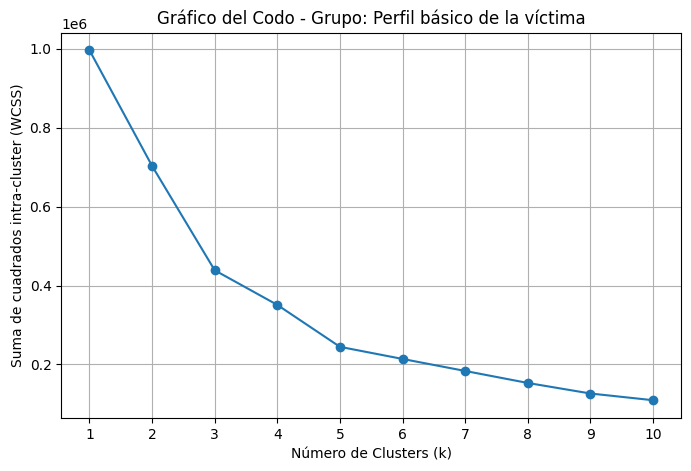

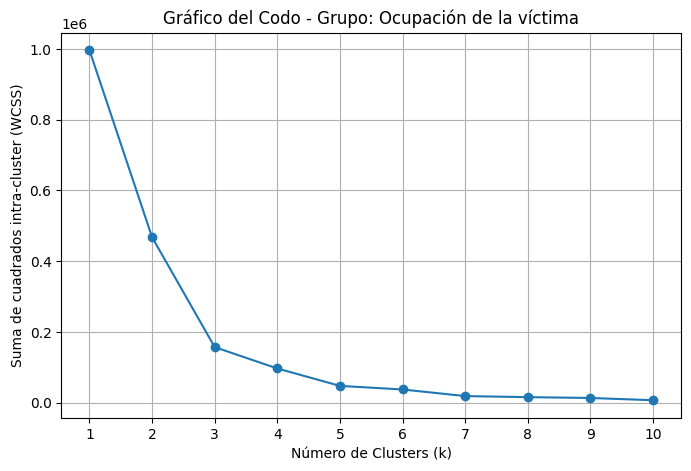

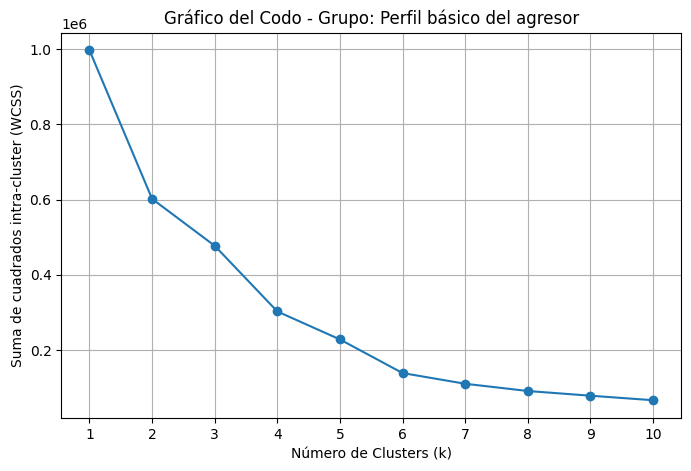

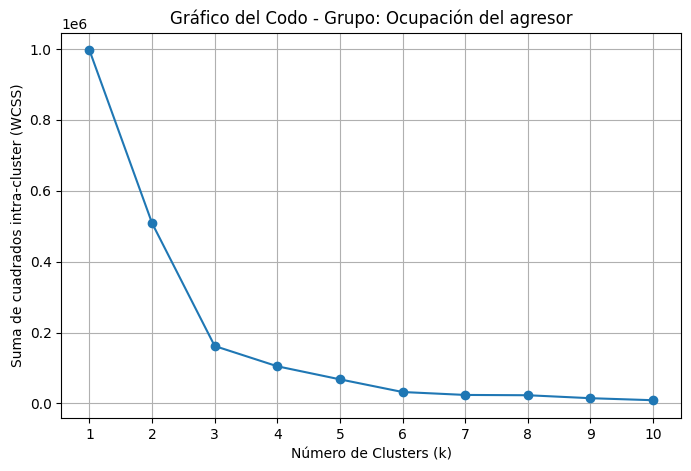

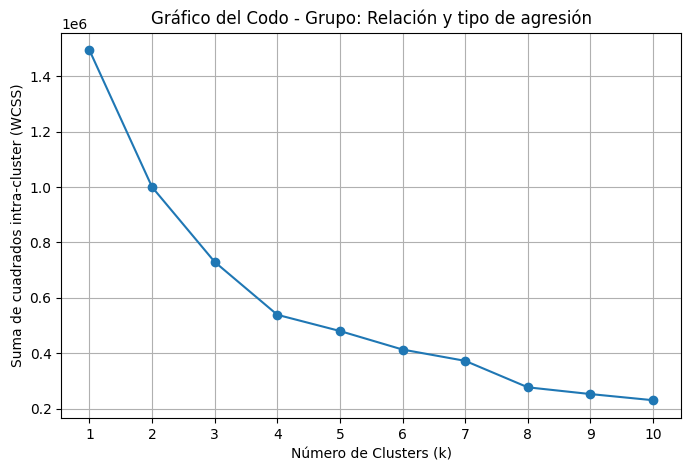

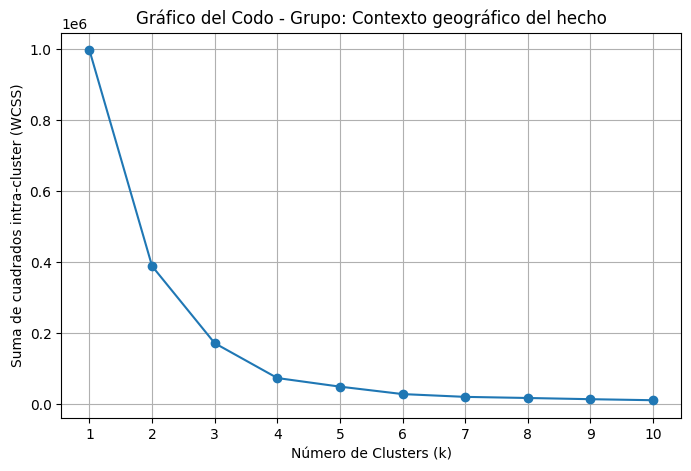

In [ ]:
elbow_plot_for_group(grupo_perfil_victima, "Grupo: Perfil básico de la víctima")
elbow_plot_for_group(grupo_ocupacion_victima, "Grupo: Ocupación de la víctima")
elbow_plot_for_group(grupo_perfil_agresor, "Grupo: Perfil básico del agresor")
elbow_plot_for_group(grupo_ocupacion_agresor, "Grupo: Ocupación del agresor")
elbow_plot_for_group(grupo_relacion_agresion, "Grupo: Relación y tipo de agresión")
elbow_plot_for_group(grupo_contexto_geografico, "Grupo: Contexto geográfico del hecho")

## Clusters recomendados para cada grupo

<small>

### Clustering del perfil básico de la víctima (3 según análisis)
Variables:
1. VIC_EDAD
2. VIC_ESCOLARIDAD

### Clustering del perfil ocupacional de la víctima (3 según análisis)
Variables:
1. VIC_OCUP
2. VIC_DEDICA

### Clustering del perfil básico del agresor (2 según análisis)
Variables:
1. AGR_EDAD
2. AGR_ESCOLARIDAD

### Clustering del perfil ocupacional del agresor (3 según análisis)
Variables:
1. AGR_OCUP
2. AGR_DEDICA

### Clustering de la relación y tipo de agresión (2 según análisis)
Variables:
1. VIC_REL_AGR
2. HEC_TIPAGRE
3. VIC_EDAD

### Clustering del contexto geográfico del hecho (2 según análisis)
Variables:
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO

</small>


## Cálculo de K-Medias

In [ ]:
# -------------- GRUPO 1: Perfil Básico de la Víctima --------------


# Seleccionar sólo las dos columnas de interés
X_perfil_victima = df_perfil_victima_scaled

# Ajustar K‑Means
km_perfil_victima = KMeans(n_clusters=3, random_state=42).fit(X_perfil_victima)
labels_perfil_victima = km_perfil_victima.labels_
centroids_perfil_victima = km_perfil_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_perfil_victima == cluster)
    plt.scatter(X_perfil_victima[mask, 0],
                X_perfil_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_victima[:, 0],
            centroids_perfil_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means  Perfil Básico de la Víctima (VIC_ESCOLARIDAD y VIC_EDAD)")
plt.xlabel("VIC_ESCOLADIRIDAD (escalada)")
plt.ylabel("VIC_EDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# -------------- GRUPO 2: Perfil Ocupacional de la Víctima --------------


# Seleccionar sólo las dos columnas de interés
X_ocupacion_victima = df_ocupacion_victima_scaled

# Ajustar K‑Means
km_ocupacion_victima = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_victima)
labels_ocupacion_victima = km_ocupacion_victima.labels_
centroids_ocupacion_victima = km_ocupacion_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_victima == cluster)
    plt.scatter(X_ocupacion_victima[mask, 0],
                X_ocupacion_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_victima[:, 0],
            centroids_ocupacion_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means  Perfil Ocupacional de la Víctima (VIC_OCUP y VIC_DEDICA)")
plt.xlabel("VIC_OCUP (escalada)")
plt.ylabel("VIC_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# -------------- GRUPO 3: Perfil Básico del Agresor --------------


# Seleccionar sólo las dos columnas de interés
X_perfil_agresor = df_perfil_agresor_scaled

# Ajustar K‑Means
km_perfil_agresor = KMeans(n_clusters=2, random_state=42).fit(X_perfil_agresor)
labels_perfil_agresor = km_perfil_agresor.labels_
centroids_perfil_agresor = km_perfil_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_perfil_agresor == cluster)
    plt.scatter(X_perfil_agresor[mask, 0],
                X_perfil_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_agresor[:, 0],
            centroids_perfil_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Perfil Básico del Agresor (AGR_EDAD y AGR_ESCOLARIDAD)")
plt.xlabel("AGR_EDAD (escalada)")
plt.ylabel("AGR_ESCOLARIDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# -------------- GRUPO 5: Perfil Ocupacional del Agresor --------------

# Seleccionar sólo las dos columnas de interés
X_ocupacion_agresor = df_ocupacion_agresor_scaled

# Ajustar K‑Means
km_ocupacion_agresor = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_agresor)
labels_ocupacion_agresor = km_ocupacion_agresor.labels_
centroids_ocupacion_agresor = km_ocupacion_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_agresor == cluster)
    plt.scatter(X_ocupacion_agresor[mask, 0],
                X_ocupacion_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_agresor[:, 0],
            centroids_ocupacion_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Perfil Ocupacional del Agresor (AGR_OCUP y AGR_DEDICA)")
plt.xlabel("AGR_OCUP (escalada)")
plt.ylabel("AGR_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# -------------- GRUPO 5: Relación y Tipo de Agresión (PCA + KMeans) --------------

# Aplicar PCA a df_relacion_agresion_scaled (3 variables) para reducir a 2 dimensiones
pca_rel_agresion = PCA(n_components=2, random_state=42)
X_pca_rel_agresion = pca_rel_agresion.fit_transform(df_relacion_agresion_scaled)

# Mostrar varianza explicada por las 2 componentes principales
print("Varianza explicada por PC1 y PC2 (Relación y tipo de agresión):", pca_rel_agresion.explained_variance_ratio_)

# Mostrar tabla de loadings (contribución de cada variable al PCA)
loadings_rel_agresion = pd.DataFrame(
    pca_rel_agresion.components_.T,
    columns=["PC1", "PC2"],
    index=["VIC_REL_AGR", "HEC_TIPAGRE", "VIC_EDAD"]
)
print("\nLoadings (contribución de cada variable al PCA):\n", loadings_rel_agresion)

# Clustering K‑Means con 2 clusters (según análisis) sobre las componentes principales
km_rel_agresion = KMeans(n_clusters=2, random_state=42).fit(X_pca_rel_agresion)
labels_rel_agresion = km_rel_agresion.labels_
centroids_rel_agresion = km_rel_agresion.cluster_centers_

# Graficar los clusters en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_rel_agresion == cluster)
    plt.scatter(X_pca_rel_agresion[mask, 0],
                X_pca_rel_agresion[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')
plt.scatter(centroids_rel_agresion[:, 0],
            centroids_rel_agresion[:, 1],
            marker='*',
            s=300,
            label='Centroides')
plt.title("K‑Means Relación y Tipo de Agresión (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# -------------- GRUPO 6: Contexto Geográfico del Hecho --------------

# Seleccionar sólo las dos columnas de interés
X_contexto_geografico = df_contexto_geografico_scaled

# Ajustar K‑Means
km_contexto_geografico = KMeans(n_clusters=2, random_state=42).fit(X_contexto_geografico)
labels_contexto_geografico = km_contexto_geografico.labels_
centroids_contexto_geografico = km_contexto_geografico.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_contexto_geografico == cluster)
    plt.scatter(X_contexto_geografico[mask, 0],
                X_contexto_geografico[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_contexto_geografico[:, 0],
            centroids_contexto_geografico[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Contexto Geográfico del Hecho (DEPTO_MCPIO y HEC_DEPTOMCPIO)")
plt.xlabel("DEPTO_MCPIO (escalada)")
plt.ylabel("HEC_DEPTOMCPIO (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()